
<a id='chap-tpgan'></a>

# Travaux pratiques : Generative Adversarial Networks

L’objectif de cette séance de TP est d’illustrer par la pratique le
fonctionnement des réseaux de neurones génératifs antagonistes (ou
*Generative Adversarial Networks*, GAN). Cette séance est un peu moins
guidée que les précédentes, n’hésitez pas à solliciter l’équipe
enseignante en cas de difficultés, notamment liées à la programmation en
PyTorch.

Rappelons pour commencer le principe des réseaux génératifs
antagonistes. Ce modèle génératif met en compétition deux réseaux de
neurones $ {D} $ et $ {G} $ que l’on appellera par la suite le
discriminateur et le générateur, respectivement.

**Note :** on trouve parfois dans la litérature une analogie avec la
falsification d’œuvres d’art. $ {D} $ est alors appelé le
« critique » et $ {G} $ est appelé le « faussaire ».

L’objectif de $ {G} $ est de transformer un bruit aléatoire
$ z $ en un échantillon $ \tilde{x} $ le plus similaire possible
aux observations réelles $ x \in \mathbf{X} $.

À l’inverse, l’objectif de $ {D} $ est d’apprendre à reconnaître les
« faux » échantillons $ \tilde{x} $ des vrais observations
$ x $.

Pour implémenter un tel modèle, commençons par importer quelques
bibliothèques et sous-modules utiles de PyTorch.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

## Jeux de données jouet

### Points sur un cercle

Dans un premier temps, considérons un jeu de données simple : des points
répartis le long du cercle unité. Une façon d’obtenir ces points est
d’échantilloner uniformément selon une loi normale et de diviser chaque
vecteur par sa norme pour le rendre unitaire :

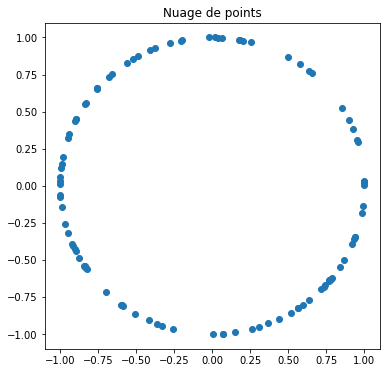

In [2]:
X = np.random.randn(100, 2)
X /= np.linalg.norm(X, axis=1)[:, None].repeat(2, axis=1)


fig = plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1])
plt.title("Nuage de points") and plt.show()

On définit ici les paramètres du problème (dimension $ n $ des
données d’entrée, ici $ n=2 $, et dimension de l’espace latent). Ils
pourront être modifiés par la suite ci-besoin.

In [3]:
data_dim = X.shape[-1]
hidden_dim = 10

### Question

Écrire en utilisant l’interface `nn.Sequential` de PyTorch:

- un générateur G entièrement connecté à 3 couches entièrement
  connectées qui projette un vecteur $ z $ de l’espace latent de
  dimension `hidden_dim` vers un échantillon de dimension
  `data_dim` (dimension des données d’entrée),  
- un discriminateur D entièrement connecté qui, à partir d’un vecteur
  de données (réel ou faux) produit en sortie un valeur entre 0 et 1
  (obtenue en passant le score dans une sigmoïde).  

### Correction

In [4]:
generator = nn.Sequential(
    nn.Linear(hidden_dim, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, data_dim)
)

discriminator = nn.Sequential(
    nn.Linear(data_dim, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

Pour créer le jeu d’apprentissage, `torch` dispose d’une fonction bien
pratique qui permet de transformer automatiquement une matrice
d’observation en `Dataset`. Nous pouvons créer le `DataLoader` dans
la foulée :

In [5]:
from torch.utils import data

dataset = data.TensorDataset(torch.Tensor(X))
dataloader = data.DataLoader(dataset, batch_size=100)

(modifiez le paramètre `batch_size` si jamais vous ne disposez pas de
suffisamment de mémoire ou si les calculs sont trop lents)

L’apprentissage des poids des réseaux $ \mathcal{D} $ et
$ \mathcal{G} $ se fait par des mises à jour séparées. Nous aurons
donc besoin de deux optimiseurs différents, un qui porte sur les
paramètres du générateur et l’autre qui portent sur les paramètres du
discriminateur :

In [6]:
G_optimizer = torch.optim.Adam(generator.parameters())
D_optimizer = torch.optim.Adam(discriminator.parameters())

### Question

Compléter la boucle d’apprentissage ci-dessous, et notamment le calcul
des fonctions de coût pour le générateur et pour le discriminateur. On
rappelle que :

- le discriminateur cherche à maximiser
  $ \mathcal{L}_D = \log D(x) + \log(1-\hat{x}) $ où $ x $ sont
  des données réelles et $ \hat{x} $ des données générées
  ($ \hat(x) = G(z) $), c’est-à-dire que la sortie de la sigmoïde
  du discriminateur doit valoir 1 pour les données réelles et 0 pour
  les données fausses,  
- le générateur cherche à minimiser
  $ \mathcal{L}_G = \log (1 - \hat{x}) = \log (1 - D(G(z)) $, c’est
  à dire tromper le discriminateur en le poussant à prédire que des
  données fausses sont réelles.  


L’algorithme d’apprentissage du GAN est donc le suivant :

Tant que la convergence n’est pas atteinte

1. Tirer un batch $ x $ de données réelles  
1. Tirer un bruit aléatoire $ z \in \mathcal{N}(0,1) $  
1. Générer des fausses données $ G(z) $  
1. Calculer la fonction de coût de $ D $ sur les données réelles + fausses  
1. Faire un pas d’optimisation de $ D $  
1. Calculer la fonction de coût de $ G $ sur les données synthétiques  
1. Faire un pas d’optimisation sur $ G $  


On rappelle que la méthode `.backward()` permet de rétropropager les
gradients d’un tenseur et que `optimizer.step()` permet ensuite de
réaliser un pas de descente de gradient (mise à jour des poids).

**Attention**: il ne faut pas rétropropager le gradient dans $ G $
lorsque vous réalisez une itération sur $ D $. Cela peut se faire à
l’aide de la méthode `.detach()` qui permet de signifier à PyTorch que
vous n’aurez pas besoin du gradient pour le tenseur concerné.

In [7]:
from tqdm.notebook import tqdm, trange

### Correction

In [8]:
for epoch in trange(10000):
    for real_data, in dataloader:
        bs = len(real_data)

        # Échantillonne des codes au hasard dans l'espace latent
        z = torch.randn((len(real_data), hidden_dim))

        fake_data = generator(z)
        predictions = discriminator(fake_data)

        # Classe "faux" = 0
        fake_labels =  torch.zeros(len(fake_data))
        # Classe "vrai" = 1
        true_labels = torch.ones(len(real_data))

        # Entraîne le générateur
        G_optimizer.zero_grad()
        G_loss = torch.log(1 - predictions).mean()
        G_loss.backward()
        G_optimizer.step()

        # Entraîne le discriminateur
        D_optimizer.zero_grad()
        predictions = discriminator(fake_data.detach())[:,0]
        true_predictions = discriminator(real_data)[:,0]
        D_loss = 0.5 * (F.binary_cross_entropy(predictions, fake_labels) + F.binary_cross_entropy(true_predictions, true_labels))
        D_loss.backward()
        D_optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

### Question

Tirez aléatoirement des vecteurs $ z $ de bruit selon une loi
normale. Générez les points associés et visualisez côte à côte le nuage
de points réel et le nuage de points synthétique.

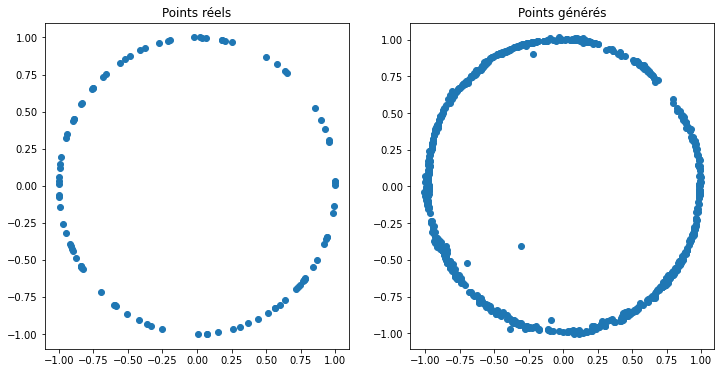

In [9]:
z = torch.randn(1000, hidden_dim)
with torch.no_grad():
    samples = generator(z)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.scatter(real_data[:, 0], real_data[:, 1])
plt.title("Points réels")
fig.add_subplot(122)
plt.scatter(samples[:, 0], samples[:, 1])
plt.title("Points générés")
plt.show()

### Question

Jusqu’à quelle valeur pouvez diminuer la dimension de l’espace latent de ce GAN ? Pourquoi ?

### Question

Colorez les points générés en fonction de la classe (“real” ou “fake”) prédite par le discriminateur. On mettera le seuil à 0.5.

### Demi-lunes

### Question

*Optionnel (passez cette question si vous êtes pressés)* Remplacez le
jeu de données $ \mathbf{X} $ défini plus haut par les deux
demi-lunes ci-dessous et répondez aux mêmes questions.

In [15]:
# 1- Generating a dataset.
from sklearn.datasets import make_moons, make_swiss_roll

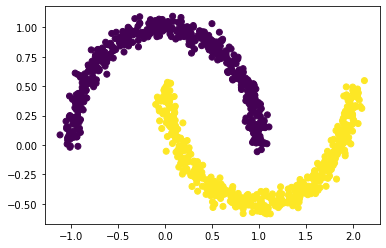

In [13]:
X, y = make_moons(n_samples=1000, noise=0.05)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

### Swiss roll

Le *swiss roll* (gâteau roulé) est un jeu de données tridimensionnel
formant un plan replié sur lui-même.

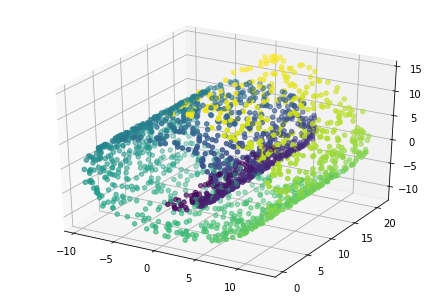

In [16]:
X, y = make_swiss_roll(n_samples=2000, noise=0.05)
import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.scatter(X[:, 0], X[:,1], X[:,2], c=y)
plt.show()

### Question

*Optionnel (passez cette question si vous êtes pressés*) Répétez l’expérience ci-dessous. Que constatez-vous lorsque vous
diminuez la dimensionalité de l’espace latent ?

## Génération de chiffres manuscrits avec MNIST

## Question

Reprendre le code précédent et l’adapter à la dimensionalité de MNIST.
On rappelle qu’une image de MNIST est de dimensions $ 28\times28 $,
c’est-à-dire un vecteur de dimension 784 une fois aplati.

Implémenter un GAN **conditionnel** sur MNIST. On utilisera comme
vecteur de conditionnement $ y $ la classe du chiffre sous forme de
vecteur suivant l’encodage *one-hot*. Visualiser les chiffres obtenus.

## Correction

In [5]:
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_mnist = MNIST(root="./data/", train=True, download=True, transform=ToTensor())
mnist_loader = data.DataLoader(train_mnist, shuffle=True, batch_size=128, num_workers=1)
device = "cuda" if torch.cuda.is_available else "cpu" # Utilise le GPU si disponible

Définition du générateur et du discriminateur :

In [6]:
hidden_dim = 100
data_dim = 784

generator = nn.Sequential(
    nn.Linear(hidden_dim + 10, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, data_dim),
    nn.Sigmoid(),
)

discriminator = nn.Sequential(
    nn.Linear(data_dim + 10, 64),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(64, 64),
    nn.Dropout(),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)
G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

In [7]:
def plot_images(generator, z, digit=0):
    c = torch.zeros((10, 10))
    c[:, digit] = 1.
    z = torch.concat((z, c), dim=1)
    z = z.to(device)
    with torch.no_grad():
        samples = generator(z)
    fig, axis = plt.subplots(1, 10, figsize=(15, 10))
    for idx, sample in enumerate(samples):
        sample = sample.to("cpu").numpy().reshape(28, 28)
        axis[idx].imshow(sample, cmap="gray")
        axis[idx].axis("off")
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0; Discriminator: 0.698, Generator: 0.924


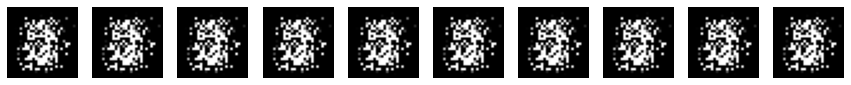

Epoch 1; Discriminator: 0.202, Generator: 3.494


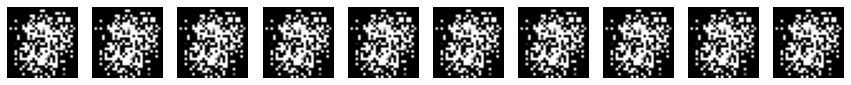

Epoch 2; Discriminator: 0.396, Generator: 1.619


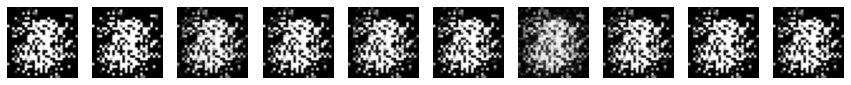

Epoch 3; Discriminator: 0.251, Generator: 2.303


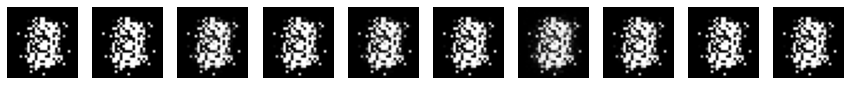

Epoch 4; Discriminator: 0.253, Generator: 2.169


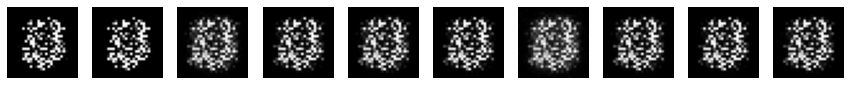

Epoch 5; Discriminator: 0.441, Generator: 0.929


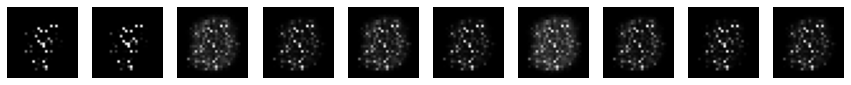

Epoch 6; Discriminator: 0.298, Generator: 1.469


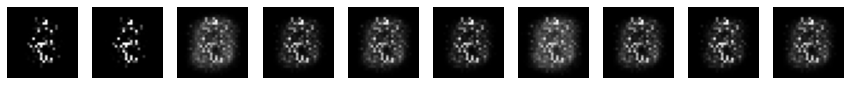

Epoch 7; Discriminator: 0.181, Generator: 2.012


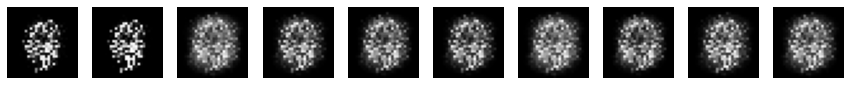

Epoch 8; Discriminator: 0.344, Generator: 2.829


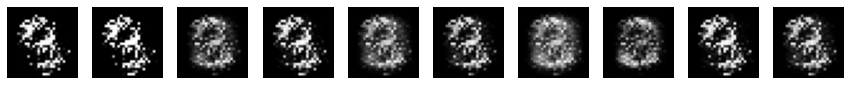

Epoch 9; Discriminator: 0.321, Generator: 2.297


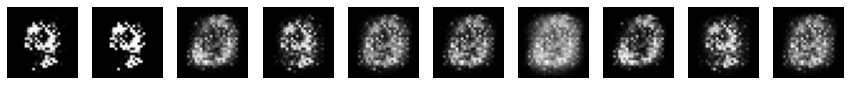

Epoch 10; Discriminator: 0.320, Generator: 1.882


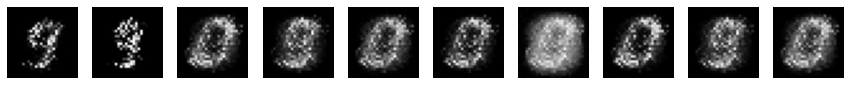

Epoch 11; Discriminator: 0.427, Generator: 1.832


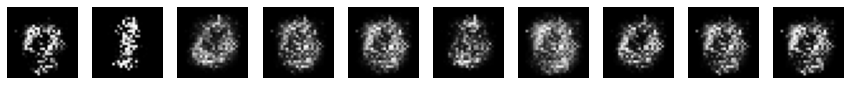

Epoch 12; Discriminator: 0.367, Generator: 2.023


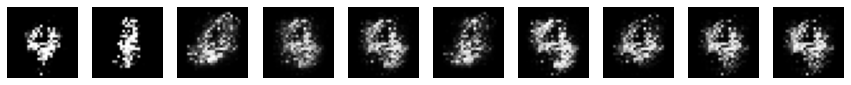

Epoch 13; Discriminator: 0.277, Generator: 1.817


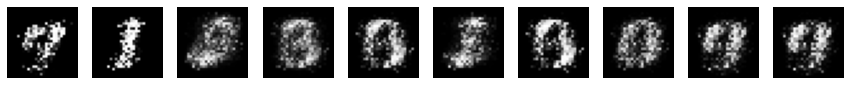

Epoch 14; Discriminator: 0.273, Generator: 2.144


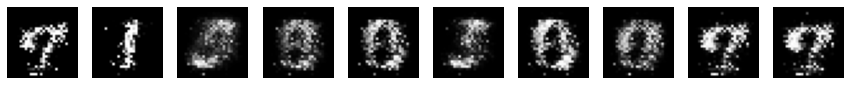

Epoch 15; Discriminator: 0.207, Generator: 2.718


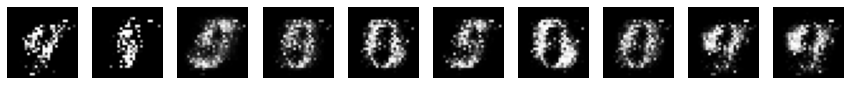

Epoch 16; Discriminator: 0.245, Generator: 2.129


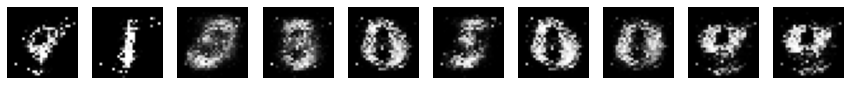

Epoch 17; Discriminator: 0.270, Generator: 2.796


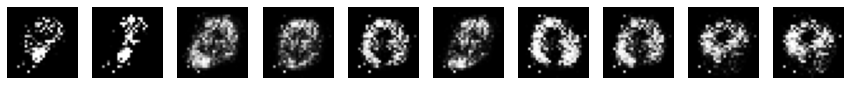

Epoch 18; Discriminator: 0.193, Generator: 1.968


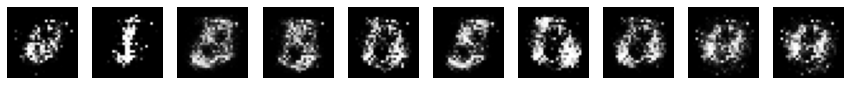

Epoch 19; Discriminator: 0.419, Generator: 2.034


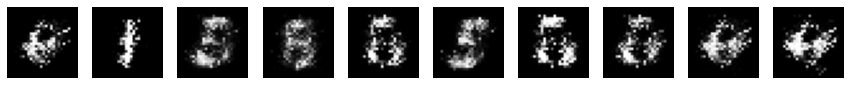

Epoch 20; Discriminator: 0.355, Generator: 2.086


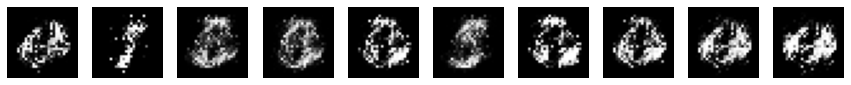

Epoch 21; Discriminator: 0.318, Generator: 2.008


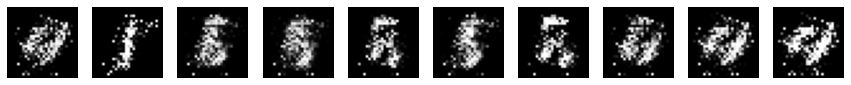

Epoch 22; Discriminator: 0.263, Generator: 1.874


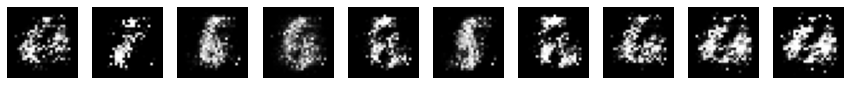

Epoch 23; Discriminator: 0.482, Generator: 1.638


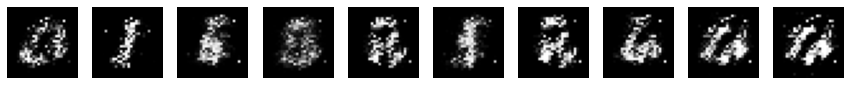

Epoch 24; Discriminator: 0.366, Generator: 1.539


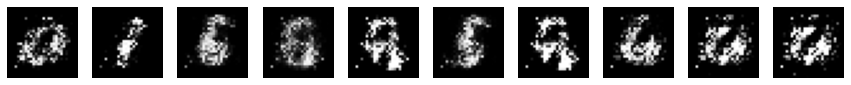

Epoch 25; Discriminator: 0.291, Generator: 1.828


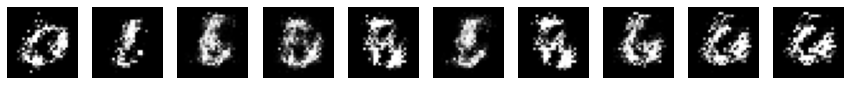

Epoch 26; Discriminator: 0.333, Generator: 1.859


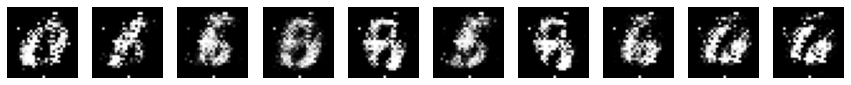

Epoch 27; Discriminator: 0.369, Generator: 1.751


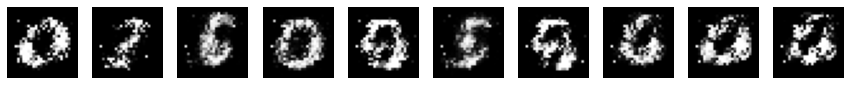

Epoch 28; Discriminator: 0.427, Generator: 1.462


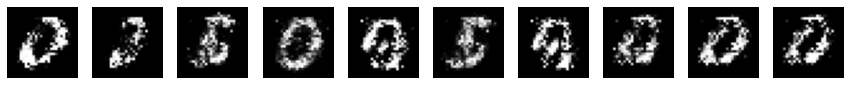

Epoch 29; Discriminator: 0.455, Generator: 1.486


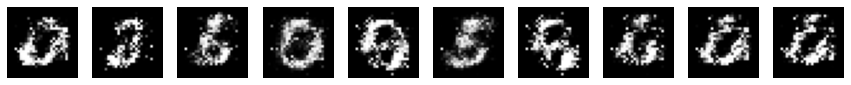

Epoch 30; Discriminator: 0.277, Generator: 1.570


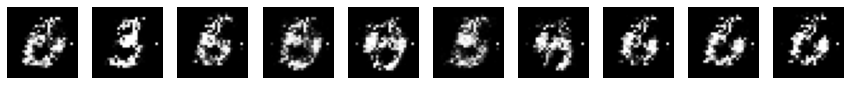

Epoch 31; Discriminator: 0.460, Generator: 1.696


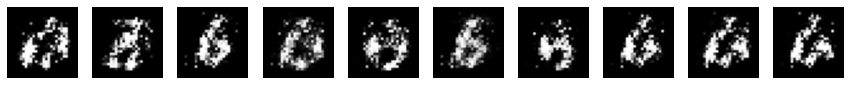

Epoch 32; Discriminator: 0.433, Generator: 1.285


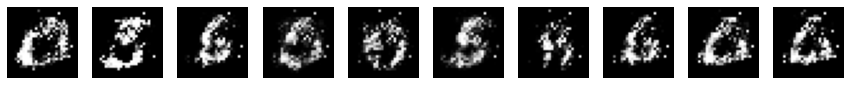

Epoch 33; Discriminator: 0.464, Generator: 1.531


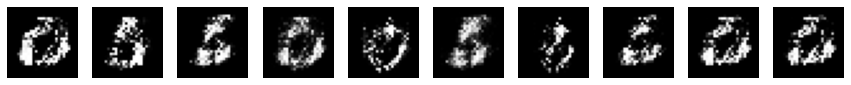

Epoch 34; Discriminator: 0.493, Generator: 1.177


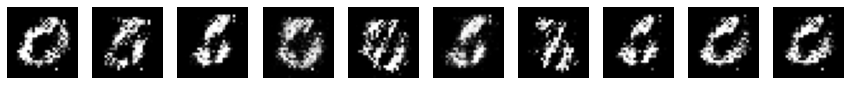

Epoch 35; Discriminator: 0.461, Generator: 1.262


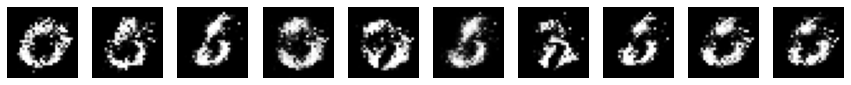

In [ ]:
from tqdm.notebook import trange, tqdm

# Déplacement des modèles sur GPU si nécessaire
generator = generator.to(device)
discriminator = discriminator.to(device)

z_display = torch.randn(10, hidden_dim)

for epoch in trange(100):
    for real_data, labels in mnist_loader:
        bs = len(real_data)

        real_data = real_data.reshape(bs, -1)
        labels = F.one_hot(labels)

        # Échantillonne des codes au hasard dans l'espace latent
        z = torch.randn((len(real_data), hidden_dim))

        # Déplacement des données sur GPU si nécessaire
        z = z.to(device)
        real_data = real_data.to(device)
        labels = labels.to(device)

        # Concaténer le conditionnement à z et aux données
        z = torch.concat((z, labels), dim=1)
        real_data = torch.concat((real_data, labels), dim=1)

        fake_data = generator(z)
        fake_data = torch.concat((fake_data, labels), dim=1) # Concatène le conditionnement
        predictions = discriminator(fake_data)

        # Classe "faux" = 0
        fake_labels =  torch.zeros(len(fake_data)).to(device)
        # Classe "vrai" = 1
        true_labels = torch.ones(len(real_data)).to(device)

        # Entraîne le générateur
        G_optimizer.zero_grad()
        #G_loss = torch.log(1 - predictions).mean()
        G_loss = F.binary_cross_entropy(predictions[:,0], true_labels)
        G_loss.backward()
        G_optimizer.step()

        # Entraîne le discriminateur
        D_optimizer.zero_grad()
        predictions = discriminator(fake_data.detach())[:,0]
        true_predictions = discriminator(real_data)[:,0]
        D_loss = 0.5 * (F.binary_cross_entropy(predictions, fake_labels) + F.binary_cross_entropy(true_predictions, true_labels))
        D_loss.backward()
        D_optimizer.step()
    tqdm.write(f"Epoch {epoch}; Discriminator: {D_loss.item():.3f}, Generator: {G_loss.item():.3f}")
    plot_images(generator, z_display)

## Question

Cette question est optionnelle et sert d’approfondissement. Remplacez
$ G $ et $ D $ définis ci-dessus par des modèles convolutifs. On
pourra notamment utiliser à bon escient les modules `Upsample` ou
`Conv2DTranspose` pour gérer l’augmentation des dimensions dans le
générateur.

## Correction

> 

In [ ]:
hidden_dim = 100
data_dim = 784

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, 7*7*3)

        self.deconvolutional = nn.Sequential(nn.Conv2d(13, 32, kernel_size=3, padding=1),
                                             nn.ReLU(),
                                             nn.UpsamplingBilinear2d(scale_factor=2),
                                             nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                             nn.ReLU(),
                                             nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                             nn.UpsamplingBilinear2d(scale_factor=2),
                                             nn.ReLU(),
                                             nn.Conv2d(64, 1, kernel_size=1, padding=0),
                                            )


    def forward(self, z, c):
        x = self.linear(z)
        x = x.reshape(x.size(0), 3, 7, 7)
        c = c[:,:,None,None].repeat(1, 1, 7, 7)
        x = torch.concat((x, c), dim=1)
        x = self.deconvolutional(x)
        x = F.sigmoid(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(nn.Conv2d(11, 16, kernel_size=3, padding=1, stride=2),
                                           nn.LeakyReLU(),
                                           nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
                                           nn.LeakyReLU(),
                                           nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),
                                           nn.LeakyReLU(),
                                           )
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(64, 1),
                                        nn.Sigmoid())

    def forward(self, x, c):
        c = c[:,:,None,None].repeat(1, 1, 28, 28)
        x = torch.concat((x, c), dim=1)
        x = self.convolutional(x)
        x = F.adaptive_avg_pool2d(x, output_size=(1,1))
        x = self.classifier(x)
        return x

generator = Generator()
discriminator = Discriminator()

G_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

In [ ]:
def plot_images(generator, z, digit=0):
   c = torch.zeros((10, 10))
   c[:, digit] = 1.
   z = z.to(device)
   c = c.to(device)
   with torch.no_grad():
       samples = generator(z, c)
   fig, axis = plt.subplots(1, 10, figsize=(15, 10))
   for idx, sample in enumerate(samples):
       sample = sample.to("cpu").numpy().reshape(28, 28)
       axis[idx].imshow(sample, cmap="gray")
       axis[idx].axis("off")
   plt.show()

In [ ]:
from tqdm.notebook import trange, tqdm

# Déplacement des modèles sur GPU si nécessaire
generator = generator.to(device)
discriminator = discriminator.to(device)

z_display = torch.randn(10, hidden_dim)

for epoch in trange(100):
    for real_data, labels in tqdm(mnist_loader):
        bs = len(real_data)

        labels = F.one_hot(labels)

        # Échantillonne des codes au hasard dans l'espace latent
        z = torch.randn((len(real_data), hidden_dim))

        # Déplacement des données sur GPU si nécessaire
        z = z.to(device)
        real_data = real_data.to(device)
        labels = labels.to(device)

        fake_data = generator(z, labels)
        predictions = discriminator(fake_data, labels)

        # Classe "faux" = 0
        fake_labels =  torch.zeros(len(fake_data)).to(device)
        # Classe "vrai" = 1
        true_labels = torch.ones(len(real_data)).to(device)

        # Entraîne le générateur
        G_optimizer.zero_grad()
        G_loss = F.binary_cross_entropy(predictions[:,0], true_labels)
        G_loss.backward()
        G_optimizer.step()

        # Entraîne le discriminateur
        D_optimizer.zero_grad()
        predictions = discriminator(fake_data.detach(), labels)[:,0]
        true_predictions = discriminator(real_data, labels)[:,0]
        D_loss = 0.5 * (F.binary_cross_entropy(predictions, fake_labels) + F.binary_cross_entropy(true_predictions, true_labels))
        D_loss.backward()
        D_optimizer.step()
    tqdm.write(f"Epoch {epoch}; Discriminator: {D_loss.item():.3f}, Generator: {G_loss.item():.3f}")
    plot_images(generator, z_display)